# 사용 패키지

In [ ]:
!pip install xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import lightgbm as lgb
#import xgboost as xgb
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Init Plugin
Init Graph Optimizer
Init Kernel


# 데이터 로드

In [3]:
total = pd.read_csv('./Data/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')
total.columns = ['date', 'hour', 'company', 'gas']


companys = total['company'].unique()
company_map = dict()
for i, company in enumerate(companys):
    company_map[company] = i
total['company'] = total['company'].map(company_map)
total['date'] = pd.to_datetime(total['date'])
total['year'] = total['date'].dt.year
total['month'] = total['date'].dt.month
total['day'] = total['date'].dt.day
total['weekday'] = total['date'].dt.weekday

total.head()
total.shape

(368088, 8)

In [14]:
company_map

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'G': 5, 'H': 6}

In [4]:

temps = []
for year in range(2013, 2019):
    temp = pd.read_csv(f'./Data/temperature_{year}.csv', encoding='cp949')
    #temp.columns = header
    temp = temp[['일시', '기온(°C)']]
    temp.columns = ['datetime', 'temperature']
    temp['datetime'] = pd.to_datetime(temp['datetime'])
    temp['year'] = temp['datetime'].dt.year
    temp['month'] = temp['datetime'].dt.month
    temp['day'] = temp['datetime'].dt.day
    temp['weekday'] = temp['datetime'].dt.weekday
    temp['hour'] = temp['datetime'].dt.hour + 1
    print(temp.shape)
    temps.append(temp)


(8760, 7)
(8760, 7)
(8760, 7)
(8784, 7)
(8756, 7)
(8759, 7)


# 전처리

In [5]:
# interpolation for 2015

print(temps[2].head())
temps[2]['datetime'].iloc[0] = pd.to_datetime("2015-01-01 00:00:00")
temps[2]['year'].iloc[0] = 2015
temps[2]['month'].iloc[0] = 1
temps[2]['day'].iloc[0] = 1
temps[2]['weekday'].iloc[0] = 3
temps[2]['hour'].iloc[0] = 1

print(temps[2].head())


             datetime  temperature  year  month  day  weekday  hour
0 2014-12-31 23:00:00         -6.2  2014     12   31        2    24
1 2015-01-01 01:00:00         -7.4  2015      1    1        3     2
2 2015-01-01 02:00:00         -8.0  2015      1    1        3     3
3 2015-01-01 03:00:00         -8.4  2015      1    1        3     4
4 2015-01-01 04:00:00         -8.8  2015      1    1        3     5
             datetime  temperature  year  month  day  weekday  hour
0 2015-01-01 00:00:00         -6.2  2015      1    1        3     1
1 2015-01-01 01:00:00         -7.4  2015      1    1        3     2
2 2015-01-01 02:00:00         -8.0  2015      1    1        3     3
3 2015-01-01 03:00:00         -8.4  2015      1    1        3     4
4 2015-01-01 04:00:00         -8.8  2015      1    1        3     5


/Users/woojaebyun/miniforge3/envs/mlp/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [6]:
# interpolation for 2017

missing_indices = pd.isnull(temps[-2].resample('1H', on='datetime', base=1).mean()).any(1).to_numpy().nonzero()[0]
print(missing_indices)

print(temps[-2].iloc[6448:6450])    
print(temps[-2].iloc[6829:6835])

calc_temp = temps[-2]['temperature'].iloc[6448:6450].mean()
print(calc_temp)
line = pd.DataFrame({"datetime": pd.to_datetime("2017-09-26 17:00:00"), 'temperature': calc_temp, "year": 2017, 'month': 9, 'day':26, \
                  'weekday':1, 'hour': 18}, index=[6449] )


lines = \
pd.DataFrame({"datetime": [pd.to_datetime("2017-10-12 15:00:00"), pd.to_datetime("2017-10-12 16:00:00"), pd.to_datetime("2017-10-12 17:00:00")], \
              'temperature': [13.5, 13.3, 13.1], \
              "year": [2017, 2017, 2017], 'month': [10, 10, 10], \
              'day':[12,12,12], 'weekday':[3,3,3], 'hour': [16,17,18]}, \
              index=[6830, 6831, 6832] )



temps[-2] = pd.concat([temps[-2].iloc[:6449], line, temps[-2].iloc[6449:6830], lines, temps[-2].iloc[6830:]]).reset_index(drop=True)

print(temps[-2].iloc[6448:6451])    
print(temps[-2].iloc[6829:6836])

[6449 6831 6832 6833]
                datetime  temperature  year  month  day  weekday  hour
6448 2017-09-26 16:00:00         30.4  2017      9   26        1    17
6449 2017-09-26 18:00:00         27.9  2017      9   26        1    19
                datetime  temperature  year  month  day  weekday  hour
6829 2017-10-12 14:00:00         13.7  2017     10   12        3    15
6830 2017-10-12 18:00:00         12.8  2017     10   12        3    19
6831 2017-10-12 19:00:00         11.5  2017     10   12        3    20
6832 2017-10-12 20:00:00         10.6  2017     10   12        3    21
6833 2017-10-12 21:00:00         10.2  2017     10   12        3    22
6834 2017-10-12 22:00:00          9.7  2017     10   12        3    23
29.15
                datetime  temperature  year  month  day  weekday  hour
6448 2017-09-26 16:00:00        30.40  2017      9   26        1    17
6449 2017-09-26 17:00:00        29.15  2017      9   26        1    18
6450 2017-09-26 18:00:00        27.90  2017      

/var/folders/cy/y3tvnwx10nqc9qqg0b1wb7wr0000gn/T/ipykernel_84186/2936941575.py:3: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  missing_indices = pd.isnull(temps[-2].resample('1H', on='datetime', base=1).mean()).any(1).to_numpy().nonzero()[0]


In [7]:
# interpolation for 2018

print(pd.isnull(temps[-1].resample('1H', on='datetime', base=1).mean()).any(1).to_numpy().nonzero()[0])
print(temps[-1].iloc[7985:7987])

calc_temp = temps[-1]['temperature'].iloc[7985:7987].mean()
print(calc_temp)
line = pd.DataFrame({"datetime": pd.to_datetime("2018-11-29 18:00:00"), 'temperature': calc_temp, "year": 2018, 'month': 11, 'day':29, \
                  'weekday':3, 'hour': 19}, index=[7986] )
temps[-1] = pd.concat([temps[-1].iloc[:7986], line, temps[-1].iloc[7986:]]).reset_index(drop=True)
                  
                  
print(temps[-1].iloc[7985:7987])


for i in range(len(temps)):
    print(temps[i].shape)


[7986]
                datetime  temperature  year  month  day  weekday  hour
7985 2018-11-29 17:00:00          5.8  2018     11   29        3    18
7986 2018-11-29 19:00:00          5.2  2018     11   29        3    20
5.5
                datetime  temperature  year  month  day  weekday  hour
7985 2018-11-29 17:00:00          5.8  2018     11   29        3    18
7986 2018-11-29 18:00:00          5.5  2018     11   29        3    19
(8760, 7)
(8760, 7)
(8760, 7)
(8784, 7)
(8760, 7)
(8760, 7)


/var/folders/cy/y3tvnwx10nqc9qqg0b1wb7wr0000gn/T/ipykernel_84186/2492857734.py:3: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  print(pd.isnull(temps[-1].resample('1H', on='datetime', base=1).mean()).any(1).to_numpy().nonzero()[0])


In [8]:
temp_combined = pd.concat(temps, axis = 0)
temp_combined.reset_index(inplace=True, drop=True)
temp_combined.shape # should be 52584

(52584, 7)

In [9]:
join_df = pd.merge(total, temp_combined, how='left', left_on=['year', 'month', 'day', 'weekday', 'hour'], right_on=['year', 'month', 'day', 'weekday', 'hour'])
join_df.drop('datetime', axis=1, inplace=True)


print(join_df.shape)
print(total.shape)


print(join_df.iloc[-5:])
print(total.iloc[-5:])

(368088, 9)
(368088, 8)
             date  hour  company      gas  year  month  day  weekday  \
368083 2018-12-31    20        6  681.033  2018     12   31        0   
368084 2018-12-31    21        6  669.961  2018     12   31        0   
368085 2018-12-31    22        6  657.941  2018     12   31        0   
368086 2018-12-31    23        6  610.953  2018     12   31        0   
368087 2018-12-31    24        6  560.896  2018     12   31        0   

        temperature  
368083         -3.1  
368084         -3.7  
368085         -4.6  
368086         -5.4  
368087         -5.2  
             date  hour  company      gas  year  month  day  weekday
368083 2018-12-31    20        6  681.033  2018     12   31        0
368084 2018-12-31    21        6  669.961  2018     12   31        0
368085 2018-12-31    22        6  657.941  2018     12   31        0
368086 2018-12-31    23        6  610.953  2018     12   31        0
368087 2018-12-31    24        6  560.896  2018     12   31       

In [10]:
daily_temp = join_df[['temperature']].groupby([ join_df['month'], join_df['day'], join_df['hour'] ]).apply(lambda c: c.mean())
print(daily_temp.shape)
daily_temp

(8784, 1)


temperature
month day hour             
1     1   1       -2.683333
          2       -3.116667
          3       -3.483333
          4       -3.716667
          5       -4.050000
...                     ...
12    31  20       0.300000
          21      -0.350000
          22      -0.916667
          23      -1.533333
          24      -1.883333

[8784 rows x 1 columns]

In [39]:
features = ['temperature', 'company', 'month', 'day', 'weekday', 'hour']

x = join_df[features]
y = join_df['gas']

x = x.values
y = np.expand_dims(y.values, axis = 1)

x_scaler = MinMaxScaler()
x_scaler.fit(x)
x = x_scaler.transform(x)

print(x.shape)
print(y.shape)

print(x[:5])
print(y[:5])

(368088, 6)
(368088, 1)
[[0.16898955 0.         0.         0.         0.16666667 0.        ]
 [0.16550523 0.         0.         0.         0.16666667 0.04347826]
 [0.16724739 0.         0.         0.         0.16666667 0.08695652]
 [0.17247387 0.         0.         0.         0.16666667 0.13043478]
 [0.17073171 0.         0.         0.         0.16666667 0.17391304]]
[[2497.129]
 [2363.265]
 [2258.505]
 [2243.969]
 [2344.105]]


# 모델 생성 및 학습

In [40]:

def make_model():    
    input_data  = layers.Input(shape=(6,))
    out         = layers.Dense(64, activation="relu")(input_data)
    out         = layers.BatchNormalization()(out)
    out         = layers.Dense(32, activation="relu")(out)
    out         = layers.BatchNormalization()(out)
    out         = layers.Dense(16, activation="relu")(out)
    out         = layers.BatchNormalization()(out)
    output      = layers.Dense(1)(out)

    model        = tf.keras.Model(inputs = input_data, outputs = output)
    
    return model

In [41]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size = 0.2, random_state = 1311, shuffle=True)


In [42]:
from tensorflow.keras import backend as K 

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

def n_mae(y_true, y_pred):
    y_true = y_scaler.inverse_transform(y_true)
    y_pred = y_scaler.inverse_transform(y_pred)
    return K.mean((K.abs(y_true-y_pred))/y_true)

model = make_model()
model.compile(optimizer='adam', loss = n_mae)
#model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
model.summary()

es = EarlyStopping(monitor='val_loss', mode = 'min' , patience = 10, verbose = 1)
folder_path = './Models/DNN_temp'
file_path = folder_path + '/Epoch_{epoch:03d}_Val_{val_loss:.3f}.hdf5'
mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min',verbose=1, save_best_only=True)


history = model.fit(train_x, train_y, epochs = 50, batch_size = 128, \
                    shuffle= True, validation_data = (valid_x, valid_y), \
                    verbose = 1, callbacks = [mc, es])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                448       
_________________________________________________________________
batch_normalization_9 (Batch (None, 64)                256       
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_10 (Batc (None, 32)                128       
_________________________________________________________________
dense_14 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_11 (Batc (None, 16)                64  

2021-10-27 20:29:54.356814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2300/2301 [============================>.] - ETA: 0s - loss: 0.9648

2021-10-27 20:30:21.548869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2301/2301 [==============================] - 29s 12ms/step - loss: 0.9648 - val_loss: 0.9182

Epoch 00001: val_loss improved from inf to 0.91822, saving model to ./Models/DNN_temp/Epoch_001_Val_0.918.hdf5
Epoch 2/50
2301/2301 [==============================] - 29s 13ms/step - loss: 0.8719 - val_loss: 0.8132

Epoch 00002: val_loss improved from 0.91822 to 0.81323, saving model to ./Models/DNN_temp/Epoch_002_Val_0.813.hdf5
Epoch 3/50
2301/2301 [==============================] - 29s 12ms/step - loss: 0.7937 - val_loss: 0.7386

Epoch 00003: val_loss improved from 0.81323 to 0.73859, saving model to ./Models/DNN_temp/Epoch_003_Val_0.739.hdf5
Epoch 4/50
2301/2301 [==============================] - 28s 12ms/step - loss: 0.7209 - val_loss: 0.6897

Epoch 00004: val_loss improved from 0.73859 to 0.68971, saving model to ./Models/DNN_temp/Epoch_004_Val_0.690.hdf5
Epoch 5/50
2301/2301 [==============================] - 29s 12ms/step - loss: 0.6623 - val_loss: 0.6259

Epoch 00005: val_loss improved

2301/2301 [==============================] - 29s 13ms/step - loss: 0.2510 - val_loss: 0.1978

Epoch 00043: val_loss improved from 0.20265 to 0.19785, saving model to ./Models/DNN_temp/Epoch_043_Val_0.198.hdf5
Epoch 44/50
2301/2301 [==============================] - 28s 12ms/step - loss: 0.2484 - val_loss: 0.1907

Epoch 00044: val_loss improved from 0.19785 to 0.19074, saving model to ./Models/DNN_temp/Epoch_044_Val_0.191.hdf5
Epoch 45/50
2301/2301 [==============================] - 27s 12ms/step - loss: 0.2473 - val_loss: 0.2158

Epoch 00045: val_loss did not improve from 0.19074
Epoch 46/50
2301/2301 [==============================] - 28s 12ms/step - loss: 0.2468 - val_loss: 0.2043

Epoch 00046: val_loss did not improve from 0.19074
Epoch 47/50
2301/2301 [==============================] - 28s 12ms/step - loss: 0.2444 - val_loss: 0.2112

Epoch 00047: val_loss did not improve from 0.19074
Epoch 48/50
2301/2301 [==============================] - 28s 12ms/step - loss: 0.2404 - val_loss: 0

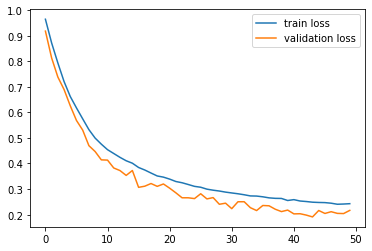

In [43]:
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

In [44]:
model = make_model()
model.load_weights('./Models/DNN_temp/Epoch_044_Val_0.191.hdf5')

# 학습

In [ ]:
from xgboost import XGBRegressor

dtrain = xgb.DMatrix(data=train_x, label = train_y)
dval = xgb.DMatrix(data=val_x, label = val_y)
wlist = [(dtrain, 'train'), (dval,'eval')]

params = {
    'learning_rate': 0.05,
    'objective': 'reg:squarederror',
    'metric':'mae', 
    'seed':42
}
 

model = xgb.train( params, dtrain, 500, evals=wlist, verbose_eval=20, early_stopping_rounds=100)

# 추론 및 결과 제출

In [45]:
test = pd.read_csv('./Submission/test.csv')
submission = pd.read_csv('./Submission/sample_submission.csv')

In [46]:
test.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [47]:
submission.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [48]:
test['datetime'] = test['일자|시간|구분'].str.split(' ').str[0]
test['hour'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['company'] = test['일자|시간|구분'].str.split(' ').str[2]

In [49]:
test['datetime'] = pd.to_datetime(test['datetime'])
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['weekday'] = test['datetime'].dt.weekday

In [50]:
test['company'] = test['company'].map(company_map)

In [51]:
test.head()

,일자|시간|구분,datetime,hour,company,year,month,day,weekday
0,2019-01-01 01 A,2019-01-01,1,0,2019,1,1,1
1,2019-01-01 02 A,2019-01-01,2,0,2019,1,1,1
2,2019-01-01 03 A,2019-01-01,3,0,2019,1,1,1
3,2019-01-01 04 A,2019-01-01,4,0,2019,1,1,1
4,2019-01-01 05 A,2019-01-01,5,0,2019,1,1,1


In [52]:
test_combined = pd.merge(test, daily_temp, how = 'left', left_on = ['month', 'day', 'hour'], right_on = ['month', 'day', 'hour'])

print(test_combined.iloc[:5])
print(test_combined.iloc[-5:])

          일자|시간|구분   datetime  hour  company  year  month  day  weekday  \
0  2019-01-01 01 A 2019-01-01     1        0  2019      1    1        1   
1  2019-01-01 02 A 2019-01-01     2        0  2019      1    1        1   
2  2019-01-01 03 A 2019-01-01     3        0  2019      1    1        1   
3  2019-01-01 04 A 2019-01-01     4        0  2019      1    1        1   
4  2019-01-01 05 A 2019-01-01     5        0  2019      1    1        1   

   temperature  
0    -2.683333  
1    -3.116667  
2    -3.483333  
3    -3.716667  
4    -4.050000  
              일자|시간|구분   datetime  hour  company  year  month  day  weekday  \
15115  2019-03-31 20 H 2019-03-31    20        6  2019      3   31        6   
15116  2019-03-31 21 H 2019-03-31    21        6  2019      3   31        6   
15117  2019-03-31 22 H 2019-03-31    22        6  2019      3   31        6   
15118  2019-03-31 23 H 2019-03-31    23        6  2019      3   31        6   
15119  2019-03-31 24 H 2019-03-31    24        6  20

In [64]:
test_x = test_combined[features]

test_x = test_x.values

test_x[59:, 0]
#test_x = x_scaler.transform(test_x)
#Etest_x[:5]



array([-1.08333333,  0.33333333,  1.48333333, ..., 11.08333333,
       10.45      ,  9.95      ])

In [ ]:
test_x = xgb.DMatrix(test_x)

In [56]:
preds = model.predict(test_x)

2021-10-27 20:54:45.790917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [57]:
submission['공급량'] = preds

In [58]:
submission.to_csv('./Submission/dnn_temp.csv', index=False)